In [11]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import RAW_DIR, PROCESSED_DIR, PROTEIN_IDS_CSV, get_paths_protein, get_paths
from src.statistics.clustering_algorithm import identify_clusters
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Clustering Algorithm 
- to identify clusters of high difference between the two models AlphaMissense and ESM1b

In [12]:
def flatten_clusters(cluster_dict):
    rows = []
    for protein_id, clusters in cluster_dict.items():
        for cluster in clusters:
            rows.append({
                "UniProtID": protein_id,
                "range": cluster["range"],
                "avg_diff": cluster["avg_diff"],
                "more pathogenic": cluster["more pathogenic"]
            })
    return pd.DataFrame(rows)


### Example for one protein

In [ ]:
id = "Q969V6"
paths = get_paths_protein(id)
matrix_diff = pd.read_csv(paths["difference_path"], index_col=0)
avg_diff = pd.read_csv(paths["difference_path"], index_col=0).mean(axis=0)


cluster_dict = identify_clusters(id, matrix_diff, threshold=0.20, search_window_size=9)
print(cluster_dict)

# Flatten and save
clusters_df = flatten_clusters(cluster_dict)
clusters_df.to_csv(get_paths()["clusters_path"] / f"{id}_clusters.csv", index=False)

### Finding clusters in all multispan proteins

In [ ]:
protein_ids = pd.read_csv(PROTEIN_IDS_CSV)
print(protein_ids)
SEARCH_WINDOW_SIZE = 9
THRESHOLD = 0.2


for protein in tqdm(protein_ids["Protein_ID"], desc="Processing proteins"):
    try:
        paths = get_paths_protein(protein)
        matrix_diff = pd.read_csv(paths["difference_path"], index_col=0)
    except FileNotFoundError:
        print(f"{protein} not found.")
        continue
    
    cluster_dict = identify_clusters(protein, matrix_diff, threshold=THRESHOLD, search_window_size=SEARCH_WINDOW_SIZE)
    
    # Flatten and save
    clusters_df = flatten_clusters(cluster_dict)
    clusters_df.to_csv(get_paths()["clusters_path"] / f"{protein}_clusters.csv", index=False)

### Compute average 2D Structure per Cluster

In [10]:
# Load cluster annotation data
# 1. Human Proteome IDs
human_proteome_ids = pd.read_csv(PROTEIN_IDS_CSV) #"Protein_ID"
# 2. n_out Proteome
nout_proteome_ids = pd.read_csv(PROCESSED_DIR / "Human_N_Out_Proteome.csv", usecols=["entry"]) #"entry"
# 3. Multispan Proteome
multispan_proteome_ids = pd.read_csv(RAW_DIR / "multipass.tsv", sep="\t") #"Entry"



count_errors = 0 
# Final results across all proteins
final_aggregate = {
    "residues_n": 0,
    "am_sum": 0.0,
    "esm_sum": 0.0,
    "rASA_sum": 0.0,
    "structure_counts": Counter(),
    "all_am_scores": [],
    "all_esm_scores": []
}

for protein_id in tqdm(nout_proteome_ids["entry"], desc="Processing proteins"):
    # Load Rank Score statistics for a protein
    try:
        cluster_df = pd.read_csv(get_paths()["clusters_path"] / f"{protein_id}_clusters.csv")
        protein_statistics = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"])   
    except:
        count_errors += 1
        print(f"{protein_id}. Skipping: {count_errors} errors encountered.")
        continue

    # Per protein aggregation
    protein_aggregate = {
        "residues_n": 0,
        "am_sum": 0.0,
        "esm_sum": 0.0,
        "rASA_sum": 0.0,
        "structure_counts": Counter()
    }

    # Plot each cluster region as a rectangle
    for _, row in cluster_df.iterrows():
        try:
            start, end = map(int, row['range'].split('-'))
        except:
            continue
        
        # Filter rows where 'residue_position' is between start and end
        filtered_rows = protein_statistics[
            (protein_statistics['residue_position'] >= start) & 
            (protein_statistics['residue_position'] <= end)
        ]
        if filtered_rows.empty:
            continue

        residues_n = len(filtered_rows)
        am_scores = filtered_rows['AM_mean'].values
        esm_scores = filtered_rows['ESM_mean'].values
        rASA_scores = filtered_rows['rASA'].values
        structure_counts = filtered_rows['2D_Structures'].value_counts()
        
        # Update per-protein aggregate
        protein_aggregate["residues_n"] += residues_n
        protein_aggregate["am_sum"] += am_scores.mean() * residues_n
        protein_aggregate["esm_sum"] += esm_scores.mean() * residues_n
        protein_aggregate["rASA_sum"] += rASA_scores.mean() * residues_n
        protein_aggregate["structure_counts"] += structure_counts

        # Store for std dev
        final_aggregate["all_am_scores"].extend(am_scores)
        final_aggregate["all_esm_scores"].extend(esm_scores)

    # Update final aggregate
    final_aggregate["residues_n"] += protein_aggregate["residues_n"]
    final_aggregate["am_sum"] += protein_aggregate["am_sum"]
    final_aggregate["esm_sum"] += protein_aggregate["esm_sum"]
    final_aggregate["rASA_sum"] += protein_aggregate["rASA_sum"]
    final_aggregate["structure_counts"] += protein_aggregate["structure_counts"]



# Compute final means and standard deviations
final_result = {
    "residues_n": final_aggregate["residues_n"],
    "AM_mean": np.mean(final_aggregate["all_am_scores"]) if final_aggregate["all_am_scores"] else None,
    "AM_std": np.std(final_aggregate["all_am_scores"]) if final_aggregate["all_am_scores"] else None,
    "ESM_mean": np.mean(final_aggregate["all_esm_scores"]) if final_aggregate["all_esm_scores"] else None,
    "ESM_std": np.std(final_aggregate["all_esm_scores"]) if final_aggregate["all_esm_scores"] else None,
    "rASA_mean": final_aggregate["rASA_sum"] / final_aggregate["residues_n"] if final_aggregate["residues_n"] else None,
    "structure_counts": dict(final_aggregate["structure_counts"])
}


print(final_result)

Processing proteins:   0%|          | 0/1534 [00:00<?, ?it/s]

Q8N423. Skipping: 1 errors encountered.
Q9BUF7. Skipping: 2 errors encountered.
Q9HD43. Skipping: 3 errors encountered.
P27930. Skipping: 4 errors encountered.
Q9HDB5. Skipping: 5 errors encountered.
P58400. Skipping: 6 errors encountered.
P42081. Skipping: 7 errors encountered.
P58401. Skipping: 8 errors encountered.
Q6ZV29. Skipping: 9 errors encountered.
P51512. Skipping: 10 errors encountered.
P25445. Skipping: 11 errors encountered.
P16109. Skipping: 12 errors encountered.
O75023. Skipping: 13 errors encountered.
P15382. Skipping: 14 errors encountered.
P14209. Skipping: 15 errors encountered.
Q9UQV4. Skipping: 16 errors encountered.
Q6UWI2. Skipping: 17 errors encountered.
A6NC97. Skipping: 18 errors encountered.
Q9Y5G1. Skipping: 19 errors encountered.
P51805. Skipping: 20 errors encountered.
P17927. Skipping: 21 errors encountered.
P28908. Skipping: 22 errors encountered.
P98153. Skipping: 23 errors encountered.
Q13445. Skipping: 24 errors encountered.
Q92637. Skipping: 25 erro

In [16]:
overall_structure_freq = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / "multispan_proteome_structures.csv")
overall_structure_freq.head(10)

# Final structure counts
structure_counts = final_result["structure_counts"]
total_cluster_residues = final_result["residues_n"]

# Mapping from DSSP code to full name
structure_codes = {
    "H": "Alpha helix",
    "B": "Beta bridge",
    "E": "Strand",
    "G": "Helix-3",
    "I": "Helix-5",
    "T": "Turn",
    "S": "Bend",
    "P": "κ‐helix",
    "-": "Disorded"
}

# Reverse mapping to easily go from full name to DSSP code
reverse_structure_codes = {v: k for k, v in structure_codes.items()}

# Add two new columns with default zero
overall_structure_freq["multispan_diff_cluster_count"] = 0
overall_structure_freq["multispan_diff_cluster_percentage"] = 0.0
overall_structure_freq["multispan_diff_cluster_count_percentage_cleaned"] = 0.0

# Fill in counts and raw percentages
for idx, row in overall_structure_freq.iterrows():
    struct_name = row["Structure"]
    dssp_code = reverse_structure_codes.get(struct_name)

    if dssp_code in structure_counts:
        count = structure_counts[dssp_code]
        percentage = count / total_cluster_residues * 100

        overall_structure_freq.at[idx, "multispan_diff_cluster_count"] = count
        overall_structure_freq.at[idx, "multispan_diff_cluster_percentage"] = percentage

# Normalize by background frequency (adjusting for representation bias)
# Formula: (actual_count / expected_count_based_on_background_freq)

total_proteome_residues = overall_structure_freq["count"].sum()

# Step 1: Compute adjusted counts (correct for representation)
adjusted_counts = []

for idx, row in overall_structure_freq.iterrows():
    observed_count = row["multispan_diff_cluster_count"]
    background_percentage = row["percentage"]  # structure frequency in whole proteome
    correction_factor = background_percentage / 100 if background_percentage > 0 else 1.0

    adjusted = observed_count / correction_factor
    adjusted_counts.append(adjusted)

# Step 2: Normalize to get percentages that sum to 100
adjusted_total = sum(adjusted_counts)
cleaned_percentages = [(x / adjusted_total) * 100 for x in adjusted_counts]

# Step 3: Assign back to DataFrame
overall_structure_freq["multispan_diff_cluster_count_percentage_cleaned"] = cleaned_percentages

In [17]:
overall_structure_freq.head(10)

,Structure,AM_mean,ESM_mean,count,percentage,multispan_diff_cluster_count,multispan_diff_cluster_percentage,multispan_diff_cluster_count_percentage_cleaned
0,Alpha helix,0.564287,0.593720,730498,52.965534,144082,49.058878,10.234602
1,Disorded,0.378367,0.383944,298133,21.616450,66151,22.523937,11.513480
2,Turn,0.489490,0.529094,97765,7.088555,21785,7.417635,11.562571
3,Strand,0.604950,0.608774,85287,6.183825,16848,5.736622,10.250517
4,Bend,0.488103,0.516105,71530,5.186359,16285,5.544925,11.813533
5,Helix-3,0.508645,0.543354,37351,2.708174,8864,3.018128,12.314244
6,κ‐helix,0.406718,0.442798,33560,2.433303,8177,2.784209,12.643063
7,Helix-5,0.617641,0.655650,18139,1.315187,3034,1.033055,8.679256
8,Beta bridge,0.589149,0.606506,6932,0.502612,1468,0.499843,10.988736


In [18]:
overall_structure_freq.to_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / "multispan_proteome_structures_with_diff_cluster.csv", index=False)

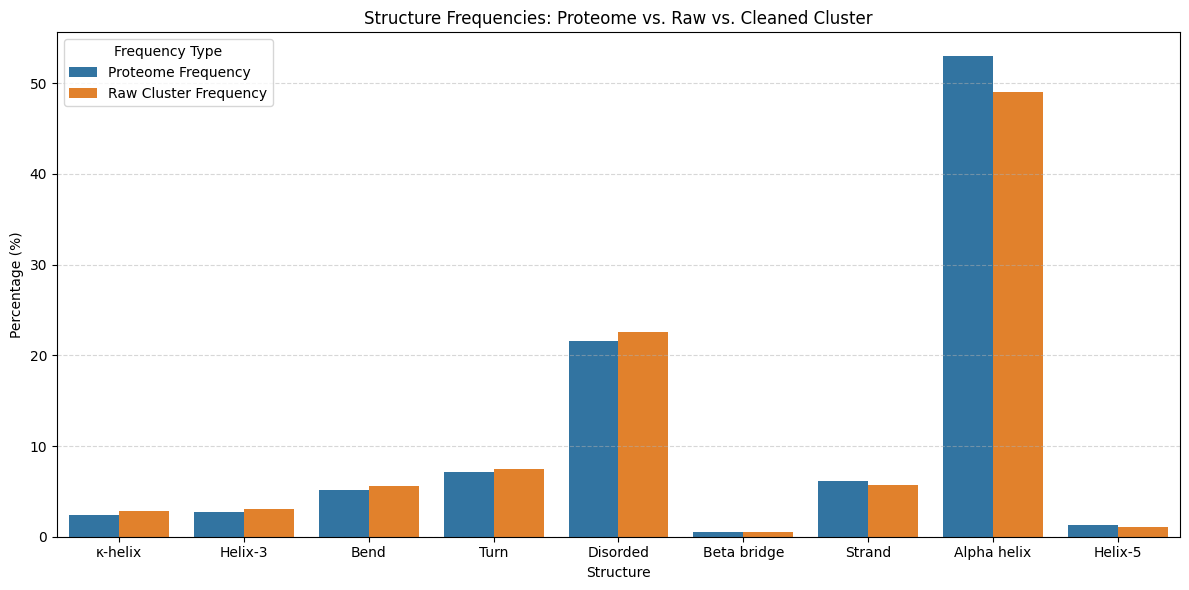

In [19]:

# Read your data
df = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / "multispan_proteome_structures_with_diff_cluster.csv")

# Sort by cleaned percentage for better readability
df = df.sort_values("multispan_diff_cluster_count_percentage_cleaned", ascending=False)

# Prepare Data for Plotting
plot_df = pd.melt(
    df,
    id_vars="Structure",
    value_vars=[
        "percentage", 
        "multispan_diff_cluster_percentage"
    ],
    var_name="Frequency_Type",
    value_name="Percentage"
)

# Rename for clarity
plot_df["Frequency_Type"] = plot_df["Frequency_Type"].replace({
    "percentage": "Proteome Frequency",
    "multispan_diff_cluster_percentage": "Raw Cluster Frequency"
})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Structure", y="Percentage", hue="Frequency_Type")
plt.xticks(rotation=0)
plt.title("Structure Frequencies: Proteome vs. Raw vs. Cleaned Cluster")
plt.ylabel("Percentage (%)")
plt.xlabel("Structure")
plt.legend(title="Frequency Type")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()